# Proyek Klasifikasi Gambar: Bahasa Isyarat Indonesia (BISINDO) Alphabets
- **Nama:** Feivel Jethro Ezhekiel
- **Email:** feiveljethroezhekiel@gmail.com
- **ID Dicoding:** MC008D5Y0587

Link Dataset Bisindo
: https://www.kaggle.com/datasets/achmadnoer/alfabet-bisindo/data

## Import Semua Packages/Library yang Digunakan

In [7]:
#%pip install tensorflow
#%pip install opencv-python pillow
#%pip install roboflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
import random
# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import models, layers, callbacks
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

In [8]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Import module yang disediakan google colab untuk kebutuhan upload file

from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"feiveljethro","key":"906bdcd2cd969068c18f46edfeadc52e"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d achmadnoer/alfabet-bisindo
!unzip alfabet-bisindo.zip

Dataset URL: https://www.kaggle.com/datasets/achmadnoer/alfabet-bisindo
License(s): CC0-1.0
alfabet-bisindo.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  alfabet-bisindo.zip
replace Citra BISINDO/A/body dot (1).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Citra BISINDO/A/body dot (1).jpg  
  inflating: Citra BISINDO/A/body dot (2).jpg  
  inflating: Citra BISINDO/A/body dot (3).jpg  
  inflating: Citra BISINDO/A/body dot (4).jpg  
  inflating: Citra BISINDO/A/body white (1).jpg  
  inflating: Citra BISINDO/A/body white (2).jpg  
  inflating: Citra BISINDO/A/body white (3).jpg  
  inflating: Citra BISINDO/A/body white (4).jpg  
  inflating: Citra BISINDO/A/wall white (1).jpg  
  inflating: Citra BISINDO/A/wall white (2).jpg  
  inflating: Citra BISINDO/A/wall white (3).jpg  
  inflating: Citra BISINDO/A/wall white (4).jpg  
  inflating: Citra BISINDO/B/body dot (1).jpg  
  inflating: Citra BISINDO/B/body dot (2).jpg  
  inf

## Data Preparation

In [5]:
# Direktori awal untuk train dan test
train_dir = "bisindo/train"
test_dir = "bisindo/test"
val_dir = "bisindo/val"

# Direktori data hasil unzip
base_dir = "Citra BISINDO"

# Direktori baru untuk dataset gabungan
combined_dir = "bisindo/dataset"

In [6]:
# Buat direktori baru untuk dataset gabungan
os.makedirs(combined_dir, exist_ok=True)

### Data Loading

In [7]:
# Iterasi semua folder A-Z
for folder_name in sorted(os.listdir(base_dir)):
    folder_path = os.path.join(base_dir, folder_name)
    # Pastikan hanya folder, bukan file lain
    if os.path.isdir(folder_path):
        for file_name in os.listdir(folder_path):
            source_path = os.path.join(folder_path, file_name)
            destination_path = os.path.join(combined_dir, f"{folder_name}_{file_name}")
            shutil.copy(source_path, destination_path)

print("Semua gambar berhasil digabung ke:", combined_dir)

Semua gambar berhasil digabung ke: bisindo/dataset


In [8]:
dataset_dir = "bisindo/dataset"

# Buat list semua file di dalam folder dataset
for filename in os.listdir(dataset_dir):
    file_path = os.path.join(dataset_dir, filename)

    # Skip jika ini folder, kita hanya mau file
    if os.path.isdir(file_path):
        continue

    # Ambil huruf pertama sebelum underscore sebagai nama kelas
    if "_" in filename:
        class_label = filename.split("_")[0].upper()  # Misalnya "A", "B", ...
    else:
        continue  # Skip file yang tidak punya format huruf_

    # Buat folder tujuan
    class_folder = os.path.join(dataset_dir, class_label)
    os.makedirs(class_folder, exist_ok=True)

    # Pindahkan file ke folder sesuai kelas
    dst_path = os.path.join(class_folder, filename)
    shutil.move(file_path, dst_path)

print("✅ Semua gambar sudah dipindahkan ke folder kelas masing-masing.")


✅ Semua gambar sudah dipindahkan ke folder kelas masing-masing.


## Penambahan jumlah dataset

In [9]:
import os
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm

# Parameter
img_height = 180
img_width = 180
target_total_images = 10000
source_dir = "bisindo/dataset"
augmented_dir = "bisindo/dataset_augmented"
os.makedirs(augmented_dir, exist_ok=True)

# Augmentation Generator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Hitung jumlah gambar saat ini
def count_images(folder_path):
    count = 0
    for root, _, files in os.walk(folder_path):
        count += len([f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    return count

# Salin gambar asli ke folder augmented (biar ikut dihitung)
for class_name in os.listdir(source_dir):
    src_class = os.path.join(source_dir, class_name)
    dst_class = os.path.join(augmented_dir, class_name)
    os.makedirs(dst_class, exist_ok=True)

    for fname in os.listdir(src_class):
        src_file = os.path.join(src_class, fname)
        dst_file = os.path.join(dst_class, fname)
        shutil.copy2(src_file, dst_file)

# Tambah gambar dengan augmentasi sampai capai target
print("\n📈 Mengaugmentasi gambar hingga mencapai", target_total_images, "gambar...\n")
for class_name in tqdm(os.listdir(source_dir), desc="Augmenting per class"):
    src_class = os.path.join(source_dir, class_name)
    dst_class = os.path.join(augmented_dir, class_name)

    for fname in os.listdir(src_class):
        img_path = os.path.join(src_class, fname)
        img = image.load_img(img_path, target_size=(img_height, img_width))
        x = image.img_to_array(img)
        x = x.reshape((1,) + x.shape)

        i = 0
        for batch in datagen.flow(x, batch_size=1,
                                  save_to_dir=dst_class,
                                  save_prefix='aug',
                                  save_format='jpg'):
            i += 1
            if count_images(augmented_dir) >= target_total_images or i >= 40:
                break
        if count_images(augmented_dir) >= target_total_images:
            break
    if count_images(augmented_dir) >= target_total_images:
        break

print("\n✅ Selesai! Total gambar sekarang:", count_images(augmented_dir))



📈 Mengaugmentasi gambar hingga mencapai 10000 gambar...



Augmenting per class:   0%|          | 0/26 [00:00<?, ?it/s]


✅ Selesai! Total gambar sekarang: 10001


### Data Preprocessing

#### Split Dataset

In [10]:
# Path asal dan tujuan
original_dataset_dir = 'bisindo/dataset_augmented'
base_dir = 'bisindo/dataset_augmented_split'

# Rasio split
train_split = 0.6
val_split = 0.25
test_split = 0.1

# Buat folder tujuan jika belum ada
for split in ['train', 'val', 'test']:
    for class_name in os.listdir(original_dataset_dir):
        os.makedirs(os.path.join(base_dir, split, class_name), exist_ok=True)

# Proses split dan copy file
for class_name in os.listdir(original_dataset_dir):
    class_dir = os.path.join(original_dataset_dir, class_name)
    if not os.path.isdir(class_dir):
        continue

    images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    random.shuffle(images)

    total = len(images)
    train_count = int(train_split * total)
    val_count = int(val_split * total)

    train_files = images[:train_count]
    val_files = images[train_count:train_count + val_count]
    test_files = images[train_count + val_count:]

    for fname in train_files:
        src = os.path.join(class_dir, fname)
        dst = os.path.join(base_dir, 'train', class_name, fname)
        shutil.copy2(src, dst)

    for fname in val_files:
        src = os.path.join(class_dir, fname)
        dst = os.path.join(base_dir, 'val', class_name, fname)
        shutil.copy2(src, dst)

    for fname in test_files:
        src = os.path.join(class_dir, fname)
        dst = os.path.join(base_dir, 'test', class_name, fname)
        shutil.copy2(src, dst)

print("✅ Dataset berhasil dibagi ke dalam folder: train, val, dan test.")

✅ Dataset berhasil dibagi ke dalam folder: train, val, dan test.


In [10]:
# Set path ke folder dataset yang telah di-split
split_dir = 'bisindo/dataset_augmented_split'
img_height = 180
img_width = 180
batch_size = 32

# Load dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(split_dir, 'train'),
    label_mode='categorical',  # gunakan 'int' jika tidak pakai one-hot
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(split_dir, 'test'),
    label_mode='categorical',  # gunakan 'int' jika tidak pakai one-hot
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(split_dir, 'val'),
    label_mode='categorical',  # gunakan 'int' jika tidak pakai one-hot
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)

Found 8671 files belonging to 26 classes.
Found 3195 files belonging to 26 classes.
Found 4742 files belonging to 26 classes.


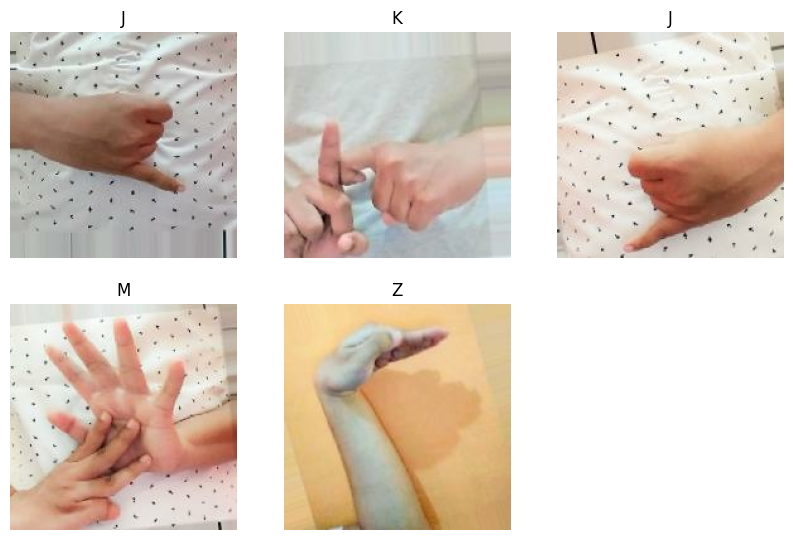

In [12]:
# Ambil 1 batch dan tampilkan 9 gambar pertama
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(5):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label_index = tf.argmax(labels[i]).numpy()
        plt.title(class_names[label_index])
        plt.axis("off")

In [13]:
train_ds.class_names

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z']

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32, 26)


In [15]:
train_count = sum(1 for _ in train_ds)
val_count = sum(1 for _ in val_ds)
test_count = sum(1 for _ in test_ds)

print(f"Train batches: {train_count}")
print(f"Validation batches: {val_count}")
print(f"Test batches: {test_count}")

Train batches: 271
Validation batches: 149
Test batches: 100


In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)
test_ds = test_ds.cache().prefetch(AUTOTUNE)

## Normalisasi

0.007843138 0.9921569


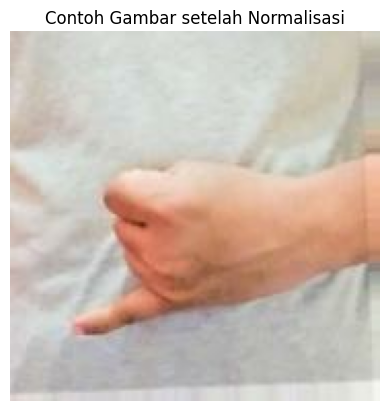

In [17]:
# Layer normalisasi
normalization_layer = layers.Rescaling(1./255)

# Terapkan ke masing-masing dataset
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

image_batch, labels_batch = next(iter(train_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))
plt.imshow(first_image)
plt.title("Contoh Gambar setelah Normalisasi")
plt.axis('off')
plt.show()

## Modelling

In [18]:
# Jumlah kelas, ambil dari train_ds
num_classes = 26

# Buat model sequential dengan Conv2D + Pooling layer
model = tf.keras.Sequential([
    #layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.48),
    layers.Dense(26, activation='softmax')
])


model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      13,107,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 26)                  │           6,682 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,207,386 (50.38 MB)

 Trainable params: 13,207,386 (50.38 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
model.compile(
    optimizer=Adam(learning_rate=0.00018),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
early_stop = callbacks.EarlyStopping(patience=5, restore_best_weights=True)

epochs = 30
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stop]
)

Epoch 1/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 33s 98ms/step - accuracy: 0.1315 - loss: 2.9776 - val_accuracy: 0.4895 - val_loss: 1.9220
Epoch 2/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.4196 - loss: 2.0048 - val_accuracy: 0.6288 - val_loss: 1.3293
Epoch 3/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 22s 49ms/step - accuracy: 0.5635 - loss: 1.4586 - val_accuracy: 0.7606 - val_loss: 0.9082
Epoch 4/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.6561 - loss: 1.1181 - val_accuracy: 0.8399 - val_loss: 0.6105
Epoch 5/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 15s 56ms/step - accuracy: 0.7324 - loss: 0.8793 - val_accuracy: 0.8781 - val_loss: 0.4632
Epoch 6/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 20s 53ms/step - accuracy: 0.7807 - loss: 0.7202 - val_accuracy: 0.8946 - val_loss: 0.3851
Epoch 7/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 18s 42ms/step - accuracy: 0.8003 - loss: 0.6183 - val_accuracy: 0.9169 - val_loss: 0.2979
Epoch 8/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 22s 49ms/step - accuracy: 0.8299 - loss: 0.5395 - 

## Evaluasi dan Visualisasi

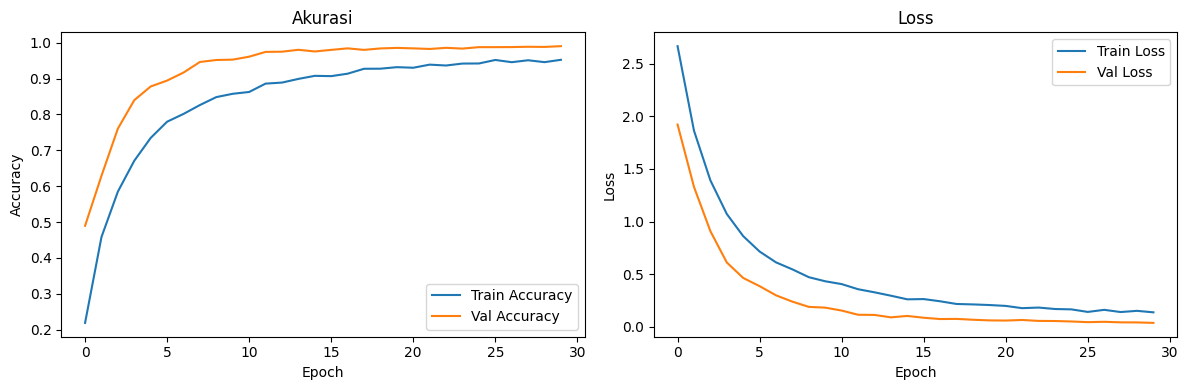

In [21]:
plt.figure(figsize=(12, 4))

# Plot akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Akurasi')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Konversi Model

### Dalam Format SavedModel

In [25]:
# Simpan dalam format SavedModel
saved_model_path = "models/"
tf.saved_model.save(model, saved_model_path)
print("✅ Model disimpan dalam format SavedModel di:", saved_model_path)

✅ Model disimpan dalam format SavedModel di: models/


In [ ]:
!pip install tensorflowjs

### Saved model to TensorFlow.js(TFJS)

In [1]:
# Konversi SavedModel ke format TFJS
import tensorflowjs as tfjs

tfjs_target_dir = "tfjs_model_bisindo"
tfjs.converters.convert_tf_saved_model(saved_model_path, tfjs_target_dir)
print("✅ Model disimpan dalam format TFJS di:", tfjs_target_dir)

✅ Model disimpan dalam format TFJS di: tfjs_model_bisindo


### Saved Model to TensorFlow Lite('.tflite')

In [29]:
# Konversi ke TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
tflite_model = converter.convert()

# Simpan file .tflite
tflite_model_path = "bisindo_model.tflite"
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print("✅ Model disimpan sebagai .tflite di:", tflite_model_path)


✅ Model disimpan sebagai .tflite di: bisindo_model.tflite


In [31]:
# Simpan label ke label.txt
with open("label.txt", "w") as f:
    for label in class_names:
        f.write(label + "\n")

print("✅ label.txt berhasil dibuat.")

✅ label.txt berhasil dibuat.


## Inference (Optional)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


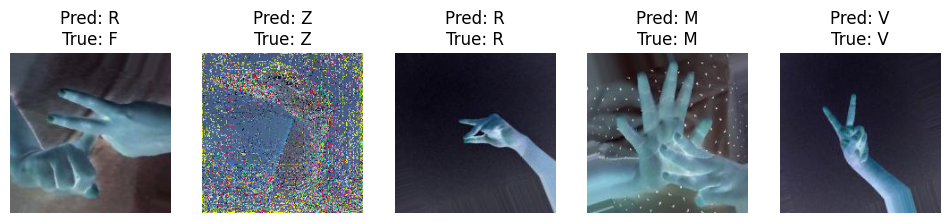

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.8506 - loss: 82.5738

📊 Akurasi pada test set: 85.45%


In [13]:
# Load model yang sudah disimpan
model = tf.keras.models.load_model("models/saved_model_bisindo.h5")

# Ambil label dari direktori dataset (misalnya 26 huruf A-Z)
class_names = sorted(os.listdir("bisindo/dataset_augmented_split/test"))

# Ambil batch pertama dari test_ds
for images, labels in test_ds.take(1):  # hanya satu batch pertama
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels.numpy(), axis=1)

    # Tampilkan 5 gambar dengan prediksi dan label
    plt.figure(figsize=(12, 6))
    for i in range(5):
        ax = plt.subplot(1, 5, i + 1)
        # Kalikan kembali ke 255 dan ubah tipe ke uint8 agar bisa ditampilkan dengan jelas
        plt.imshow((images[i].numpy() * 255).astype("uint8"))
        plt.title(f"Pred: {class_names[predicted_classes[i]]}\nTrue: {class_names[true_classes[i]]}")
        plt.axis("off")
    plt.show()

# Evaluasi performa model
loss, accuracy = model.evaluate(test_ds)
print(f"\n📊 Akurasi pada test set: {accuracy * 100:.2f}%")

## Insights

Model yang telah saya bangun telah memenuhi beberapa kriteria:
1. Jumlah dataset minimal 10.000
2. Dataset telah dibagi menjadi 3 bagian: Train, Validation, dan Test
3. Telah mengimplementasikan Callback
4. Gambar-gambar pada dataset tidak memiliki resolusi yang sama
5. Memiliki minimal 3 buah kelas(27 kelas)
6. Melakukan Inference menggunakan salah satu model(SavedModel)

Kekurangan: <br>
Memiliki akurasi diatas 95% pada data Training dan Validation, tetapi data testing diatas 85%.